# ACCESS-OM2 Preliminary Analysis

This notebook documents our first attempt to run and analyse output from the ACCESS-OM2 Pre-release, implemented at 1°.


## Current Status

### Runs So Far

|** Run Name** | **Forcing** | ** Run ** | ** Status **|
|--------------|---------|-------------------------------------------------|-------------|
|1deg_jra55_ryf_spinup1 | JRA55 RYF9091| A short 10 year spinup with first pre-release code. Had bugs in runoff and salt fluxes.| Aborted after 10 years.| 
|1deg_jra55_ryf | JRA55 RYF9091| second attempt at 1° test. | Up to 50 years.| 


### Notes
* Some diagnostics are messed up by land mask problems. This  should be fixed by year 24.
* Ocean_month files don't open properly in the spinup1 case. Just ignore these.
* I haven't done overturning properly. In fact, I may not be saving the GM terms for this run.

**Last updated 5 August 2017**

In [1]:
%matplotlib inline

from cosima_cookbook import build_index, get_nc_variable, memory
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

build_index()

# selected 025 experiments
expts = ['access-om2/1deg_jra55_ryf', 
         'access-om2/1deg_jra55_ryf_spinup1']
print(expts)


starting distributed client...
<Client: scheduler='tcp://127.0.0.1:46134' processes=8 cores=8>
Searching /g/data3/hh5/tmp/cosima/
Searching /g/data1/v45/APE-MOM
Found 37729 .nc files
Using database sqlite:////g/data1/v45/cosima-cookbook/cosima-cookbook.db
Files already indexed: 37376
Files found but not yet indexed: 353
Indexing new .nc files...

Found 5192 new variables
Saving results in database...
Indexing complete.
['access-om2/1deg_jra55_ryf', 'access-om2/1deg_jra55_ryf_spinup1']


## Wind Stress
Just a simple plot showing zonally averaged zonal wind stress from each case.

Using 62 ncfiles
chunking info ('time', 'yu_ocean', 'xu_ocean') [1, 300, 360]


/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


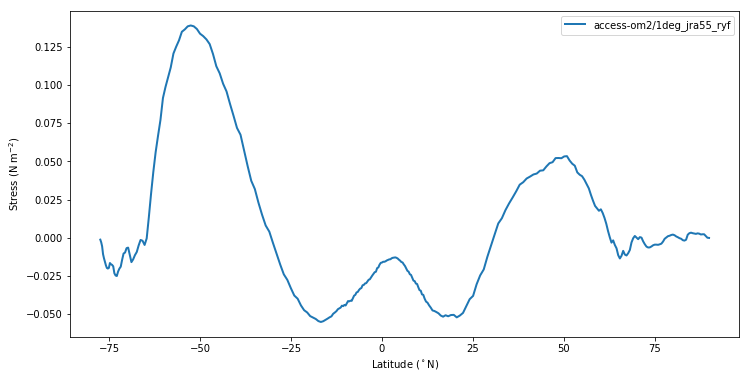

In [2]:
plt.figure(figsize=(12,6))
for e in expts[:1]:
    tau_x = get_nc_variable(e,'ocean_month.nc','tau_x',n=5)
    tau_x_bar = tau_x.mean('time').mean('xu_ocean').load()
    ## James' style file recommends we split plotting into a separate cell
    tau_x_bar.plot(linewidth=2,label=e)

plt.xlabel('Latitude ($^\circ$N)')
plt.ylabel('Stress (N m$^{-2}$)')
plt.legend(loc='upper right',fontsize=10)

## Ocean Scalars
The following series of plots shows global timeseries of key metrics.

Using 62 ncfiles
chunking info ('time', 'scalar_axis') [1, 1]
Using 10 ncfiles
chunking info ('time', 'scalar_axis') [1, 1]


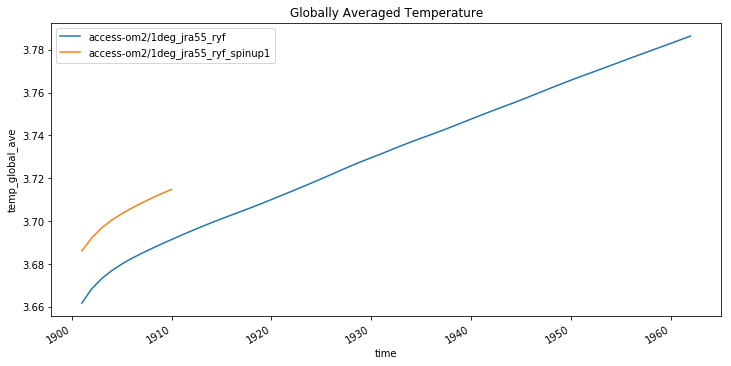

In [3]:
plt.figure(figsize=(12,6))
for e in expts:
    get_nc_variable(e,'ocean_scalar.nc','temp_global_ave',
                    time_units = 'days since 1900-01-01').resample('A','time').plot(label=e)
    
plt.legend()
plt.title('Globally Averaged Temperature')

Using 62 ncfiles
chunking info ('time', 'scalar_axis') [1, 1]
Using 10 ncfiles
chunking info ('time', 'scalar_axis') [1, 1]


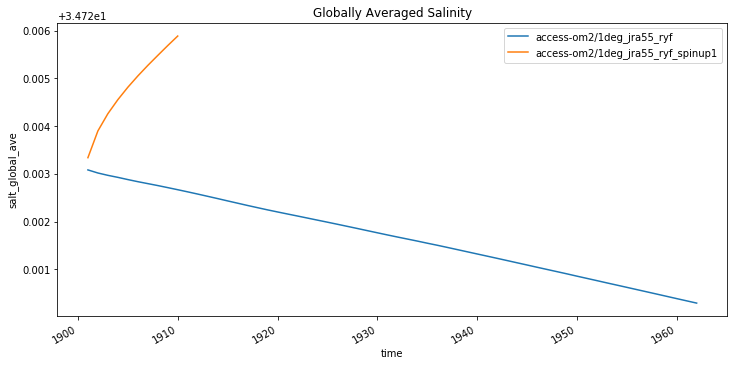

In [4]:
plt.figure(figsize=(12,6))
for e in expts:
    get_nc_variable(e,'ocean_scalar.nc','salt_global_ave',
                    time_units = 'days since 1900-01-01').resample('A','time').plot(label=e)
    
plt.legend()
plt.title('Globally Averaged Salinity')

Using 62 ncfiles
chunking info ('time', 'scalar_axis') [1, 1]
Using 10 ncfiles
chunking info ('time', 'scalar_axis') [1, 1]


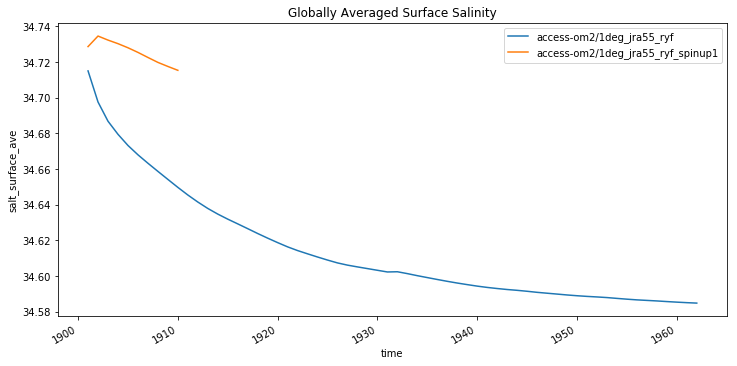

In [5]:
plt.figure(figsize=(12,6))
for e in expts:
    get_nc_variable(e,'ocean_scalar.nc','salt_surface_ave',
                    time_units = 'days since 1900-01-01').resample('A','time').plot(label=e)
    
plt.legend()
plt.title('Globally Averaged Surface Salinity')

Using 62 ncfiles
chunking info ('time', 'scalar_axis') [1, 1]
Using 10 ncfiles
chunking info ('time', 'scalar_axis') [1, 1]


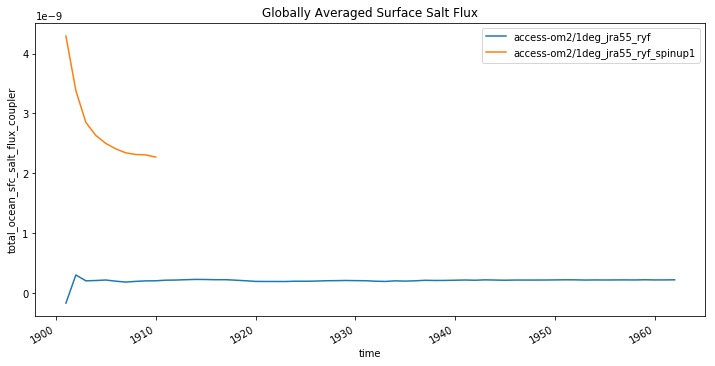

In [ ]:
plt.figure(figsize=(12,6))
for e in expts:
    get_nc_variable(e,'ocean_scalar.nc','total_ocean_sfc_salt_flux_coupler',
                    time_units = 'days since 1900-01-01').resample('A','time').plot(label=e)
    
plt.legend()
plt.title('Globally Averaged Surface Salt Flux')

## Drake Passage Transport


In [ ]:
plt.figure(figsize=(12,6))
StraightDicts = { 'DrakePassage' :  {'xloc':210,'ymin':21,'ymax':54},}
TransDict = StraightDicts['DrakePassage']
print(TransDict)
for e in expts[:1]:
    tx = get_nc_variable(e,'ocean_month.nc','tx_trans_int_z',chunks={'yt_ocean':200},
                         time_units = 'days since 1900-01-01').isel(xu_ocean=TransDict['xloc'])
    tx_trans = tx[:,TransDict['ymin']:TransDict['ymax']]
    if "access" in e:
        transport = tx.sum('yt_ocean')*1.0e-9
    else:
        transport = tx.sum('yt_ocean')
    transport.resample('A','time').plot(label=e, linewidth=2)


plt.xlabel('Latitude ($^\circ$N)')
#plt.ylabel('Stress (N m$^{-2}$)')
plt.legend(loc='upper right',fontsize=10)

{'xloc': 210, 'ymin': 21, 'ymax': 54}
Using 62 ncfiles
chunking info ('time', 'yt_ocean', 'xu_ocean') [1, 300, 360]


## Overturning circulation
First we plot mean overturning for the final decade of the simulation.
THen we look at overturning timeseries.

** This calculation also needs us to treat landmasked tiles.**

In [ ]:
@memory.cache
def calc_psi_avg(expt):
    print('Calculating {} psi_avg'.format(expt))
    
    op = lambda p: p.sum('grid_xt_ocean').cumsum('potrho')

    psi = get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                        op=op,
                        chunks={'potrho': None}, n=10)

    psi_avg = psi.mean('time')
    psi_avg = psi_avg.compute()
    
    return psi_avg

In [ ]:
def plot_psi(psi_avg, expt, clev=np.arange(-20,20,2)):

    plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    plt.title('Overturning in %s' % expt)

In [ ]:
### This plots the resolved overturning - there are no eddy fluxes here!
for expt in expts[:1]: 
    plt.figure(figsize=(8, 6)) 
    if "access" in expt:
        svfac = 1.0e-9
    else:
        svfac = 1.0
    psi_avg = svfac*calc_psi_avg(expt)
    plot_psi(psi_avg, expt)

In [ ]:
@memory.cache
def calc_psi_time(expt):
    print('Calculating {} timeseries of transport '.format(expt))
    
    op = lambda p: p.sum('grid_xt_ocean').cumsum('potrho')

    psi = get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          op=op,n=10,
                          time_units = 'days since 1900-01-01')

    psi_aabw = psi[:,60:,50].min('potrho').resample('3A',dim='time')
    psi_aabw = psi_aabw.compute()
    psi_amoc = psi[:,60:,192].max('potrho').resample('3A',dim='time')
    psi_amoc = psi_amoc.compute()
    psi_amoc_south = psi[:,60:,70].max('potrho').resample('3A',dim='time')
    psi_amoc_south = psi_amoc_south.compute()
    
    return psi_aabw, psi_amoc, psi_amoc_south

In [ ]:
plt.figure(figsize=(10, 10)) 
for e in expts[:1]: 
    #psi_aabw = calc_psi_time(e)
    psi_aabw,psi_amoc,psi_amoc_south = calc_psi_time(e)
    
    # This is a fudge because ACCESS-OM2 units are in kg/s!!
    if "access" in e:
        psi_aabw = 1.0e-9*psi_aabw
        psi_amoc = 1.0e-9*psi_amoc
        psi_amoc_south = 1.0e-9*psi_amoc_south
        
    plt.subplot(121)
    psi_aabw.plot()
    plt.subplot(222)
    psi_amoc.plot()
    plt.subplot(224)
    psi_amoc_south.plot(label=e)
    
plt.legend()

## Surface Fields
Let's look at mean surface temperature and salinity averaged over the last decade.

In [ ]:
e = expts[0]
plt.figure(figsize=(10, 6)) 
sst = get_nc_variable(e, 'ocean.nc', 'temp',n=10).isel(st_ocean=0)
sst = sst.mean('time') - 273.15  ## This because ACCESS-OM2 outputs are different to MOM.
sst.plot()
plt.title(e)

#plt.figure(figsize=(10, 6)) 
#diff = sst - sst2
#diff.plot()
#plt.title('diff')

In [ ]:
e = expts[0]
plt.figure(figsize=(10, 6)) 
sss = get_nc_variable(e, 'ocean.nc', 'salt',n=10).isel(st_ocean=0)
sss = sss.mean('time')
sss.plot()
plt.title(e)

#plt.figure(figsize=(10, 6)) 
#diff = sss - sss2.values
#diff.plot()
#plt.title('diff')

## Sea Ice
This part will plot the sea ice extent, compared with obs.

**NOT WORKING YET - still working on CICE output.**

In [ ]:
# Assume all files have same grid
#area_t_south = get_nc_variable(e,'ocean_grid.nc','area_t').sel(yt_ocean=slice(-90,-30)).values
#area_t_north = get_nc_variable(e,'ocean_grid.nc','area_t').sel(yt_ocean=slice(30,90)).values
GridFile = '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091/output000/ocean_grid.nc'
dsg = xr.open_dataset(GridFile, decode_times=False, engine='netcdf4')
area_t_south = dsg.area_t.sel(yt_ocean=slice(-90,-30)).values
area_t_north = dsg.area_t.sel(yt_ocean=slice(30,90)).values

## Doing MOM case
e = expts[-1]
plt.figure(figsize=(12,8))
plt.subplot(121)
ice_area_south = get_nc_variable(e,'ice_month.nc','EXT',
                               time_units='days since 1900-01-01').sel(yt=slice(-90,-30)).groupby('time.month').mean('time')*area_t_south/1.0e6
ice_area_south.sum(dim='xt').sum(dim='yt').plot(marker='o',label=expt)

plt.subplot(122)    
ice_area_north = get_nc_variable(e,'ice_month.nc','EXT',
                               time_units='days since 1900-01-01').sel(yt=slice(30,90)).groupby('time.month').mean('time')*area_t_north/1.0e6
ice_area_north.sum(dim='xt').sum(dim='yt').plot(marker='o',label=expt)

# sea ice observation data here:
ObsDirExt = '/g/data/v45/akm157/data/NSIDC/NOAA_G02135_extent_monthly/'
obsExtSHFileList = glob(os.path.join(ObsDirExt, 'sh/*.csv'))
obsExtSHFileList.sort()
obsExtNHFileList = glob(os.path.join(ObsDirExt, 'nh/*.csv'))
obsExtNHFileList.sort()

## Now for ACCESS case


## obs extent:
# just take 20 years 1979-1998 where available:
SH_extent_climatology_obs = np.zeros(12)
import csv
for month in range(12):
	n_years = 0
	#print('opening '+obsExtSHFileList[month])
	with open(obsExtSHFileList[month]) as csvfile:
		reader = csv.reader(csvfile)
		rownum = 0
		for row in reader:
			if (rownum > 0 and float(row[-2])>0 and float(row[0])>1978 \
				and float(row[0])<1999):
				SH_extent_climatology_obs[month] += float(row[-2])
				n_years = n_years + 1
			rownum = rownum + 1
	SH_extent_climatology_obs[month] = SH_extent_climatology_obs[month] / n_years

NH_extent_climatology_obs = np.zeros(12)
import csv
for month in range(12):
	n_years = 0
	#print('opening '+obsExtNHFileList[month])
	with open(obsExtNHFileList[month]) as csvfile:
		reader = csv.reader(csvfile)
		rownum = 0
		for row in reader:
			if (rownum > 0 and float(row[-2])>0 and float(row[0])>1978 \
				and float(row[0])<1999):
				NH_extent_climatology_obs[month] += float(row[-2])
				n_years = n_years + 1
			rownum = rownum + 1
	NH_extent_climatology_obs[month] = NH_extent_climatology_obs[month] / n_years

# plot northern:
plt.subplot(122)
plt.plot(np.arange(12)+1,NH_extent_climatology_obs*1e6,'k--',linewidth=2,label='obs')
plt.title('NH sea ice extent')
plt.legend()
#plt.ylabel(r'Sea ice extent (10$^{12}$m$^2$)')
#plt.title('Arctic extent')
#plt.show()

# plot southern:
plt.subplot(121)
plt.plot(np.arange(12)+1,SH_extent_climatology_obs*1e6,'k--',linewidth=2,label='obs')
plt.title('SH sea ice extent')
#plt.ylabel(r'Sea ice extent (10$^{12}$m$^2$)')
#plt.title('Antarctic extent')
#plt.show()


In [ ]:

ice_area_south = get_nc_variable(e,'iceh*-01.nc','aice')#.sel(yt=slice(-90,-30)).mean('time')*area_t_south/1.0e6
ice_area_south.sum(dim='xt').sum(dim='yt').plot(marker='o',label=expt)
